In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random
from random import sample

from tqdm import tqdm_notebook
# from tqdm.notebook import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

from PIL import Image
#from tqdm.notebook import tqdm
# pip install ipywidgets

import warnings
warnings.filterwarnings("ignore")

This kernel demonstrates a quick and naive implementation of a U-Net in Pytorch, trained on a GPU. Enjoy!

# Image Preparation

The following image preparation was taken almost verbatim from another excellent kernel of the TGS Salt Identification challenge: https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics. I take no credit for it.  

In [2]:
# Set some parameters# Set s 
im_width = 128
im_height = 128
im_chan = 1
path_train = '../external/isic2018/train'
path_test = '../external/isic2018/val'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")

In [3]:
train_path_images_list = glob(os.path.join(train_path_images, "*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.png"))

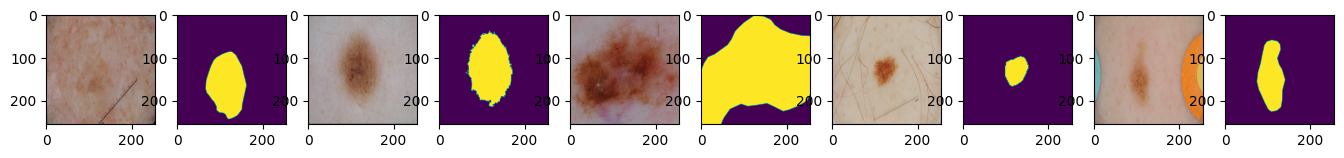

In [4]:
demos = []
for filename in os.listdir(train_path_images):
    if filename.endswith((".png", ".jpg", ".jpeg", ".bmp")):
        demos.append(filename) 
ids = sample(demos, 5)
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread(train_path_images + "/" + img_name)
    img_mask = imread(train_path_masks + "/" + img_name)
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [5]:
train_ids = next(os.walk(train_path_images))[2]
test_ids = next(os.walk(test_path_images))[2]

In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


  0%|          | 0/1886 [00:00<?, ?it/s]

Done!


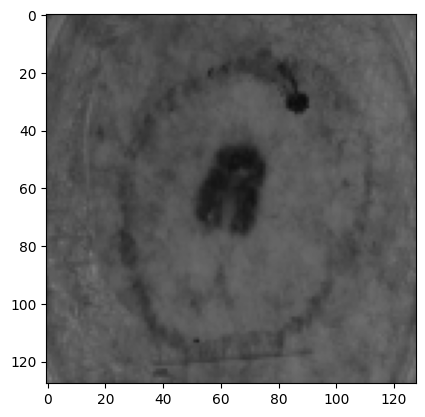

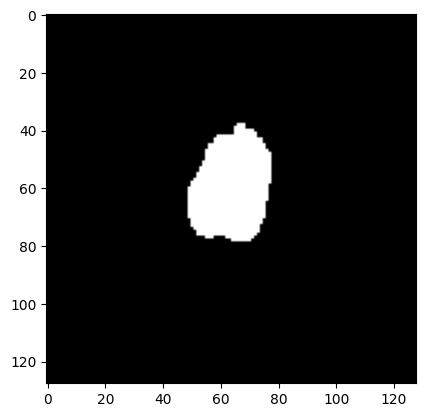

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Prepare Images for Pytorch

The following is what allows us to easily use our with Pytorch. We create a class with the following methods which then allows us to use a DataLoader.

In [8]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class Dataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [9]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)/255
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [10]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

We set a random seed for reproducibility.

In [11]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [12]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 1/10
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]

You may need to tweak your batch_size based on how much memory you have on your GPU.

In [13]:
dataset_train = Dataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
dataset_val = Dataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

# Define U-Net Model

Here's the meat of the kernel, where we define our U-Net architecture. See also this excellent kernel from an older challenge: https://www.kaggle.com/mlagunas/naive-unet-with-pytorch-tensorboard-logging.

In [14]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
        
        return one_by_one

We define a BCEWithLogitsLoss since we're comparing pixel by pixel. In addition, we didn't include a final sigmoid activation as this loss function includes a sigmoid for us.

In [15]:
model = Unet()
# model.cuda();
model.cpu();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# 差分隱私參數
noise_multiplier = 1.0   # 噪聲倍數，越大越保護隱私
max_grad_norm = 1.0      # 梯度裁剪的範圍
batch_size = 8               # 批次大小
sample_size = 1000           # 總樣本大小
delta = 1e-5                 # 隱私失效概率

# 設定隱私預算 (假設我們希望 ε 不超過 5.0)
privacy_budget = 5.0

In [17]:
import math

def compute_epsilon(steps, noise_multiplier, batch_size, sample_size, delta):
    """
    計算累積隱私損失 ε。
    
    參數:
        steps (int): 訓練步驟次數
        noise_multiplier (float): 噪聲倍率
        batch_size (int): 批次大小
        sample_size (int): 數據總量
        delta (float): 隱私失效概率
    
    返回:
        epsilon (float): 隱私損失 ε
    """
    if noise_multiplier == 0:
        return float('inf')
    
    # 每步驟的數據採樣率
    q = batch_size / sample_size
    
    # Renyi Differential Privacy 的 orders
    orders = torch.arange(2, 64).float()
    
    # 計算每個 order 的 RDP 值
    rdp = [(q**2) * (order / (2 * noise_multiplier**2)) for order in orders]
    rdp_sum = steps * torch.tensor(rdp)
    
    # 計算對應的 epsilon
    epsilon = min(rdp_sum + torch.log(torch.tensor(1 / delta)) / (orders - 1))
    return epsilon.item()

In [18]:
import torch.nn.utils as nn_utils

def apply_dp_sgd(model, noise_multiplier, max_grad_norm):
    """
    對模型的梯度進行差分隱私處理。
    
    參數:
        model (torch.nn.Module): 神經網絡模型
        noise_multiplier (float): 噪聲倍率
        max_grad_norm (float): 梯度裁剪上限
    """
    for param in model.parameters():
        if param.grad is not None:
            # 將梯度裁剪到 max_grad_norm 的範圍內
            param.grad.data = torch.clamp(param.grad.data, -max_grad_norm, max_grad_norm)
            
            # 添加高斯噪聲到梯度
            noise = torch.randn_like(param.grad) * noise_multiplier * max_grad_norm
            param.grad.data += noise

In [19]:
import numpy as np
from torch.autograd import Variable

mean_train_losses = []
mean_val_losses = []
steps = 0  # 初始化總步數

for epoch in range(30):
    train_losses = []
    val_losses = []
    
    # 訓練階段
    model.train()
    for images, masks in train_loader:
        steps += 1  # 每次訓練步驟累積總步數
        # images = Variable(images.cuda())
        # masks = Variable(masks.cuda())
        # 將數據移動到 CPU 或 GPU
        images = Variable(images.cpu())
        masks = Variable(masks.cpu())
        
        # 前向傳播
        outputs = model(images)
        
        # 計算損失
        loss = criterion(outputs, masks)
        train_losses.append(loss.data.item())  # 儲存每個批次的損失

        # 反向傳播
        optimizer.zero_grad()
        loss.backward()
        
        # 應用差分隱私的梯度處理
        apply_dp_sgd(model, noise_multiplier, max_grad_norm)
        
        # 更新參數
        optimizer.step()
    
    # 每個 epoch 結束後，計算累積的 epsilon
    epsilon = compute_epsilon(steps, noise_multiplier, batch_size, sample_size, delta)
    print(f"Epoch {epoch + 1}: ε = {epsilon:.2f}, δ = {delta}")
    
    # 檢查是否超過隱私預算
    if epsilon > privacy_budget:
        print(f"達到隱私預算: ε = {epsilon:.2f}, 停止訓練")
        break

    # 訓練階段平均損失
    mean_train_loss = np.mean(train_losses)
    mean_train_losses.append(mean_train_loss)

    # 驗證階段
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            # images = Variable(images.cuda())
            # masks = Variable(masks.cuda())
            images = Variable(images.cpu())
            masks = Variable(masks.cpu())
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_losses.append(loss.data.item())  # 儲存每個批次的驗證損失

    # 驗證階段平均損失
    mean_val_loss = np.mean(val_losses)
    mean_val_losses.append(mean_val_loss)

    # Print train and validation loss
    print(f'Epoch: {epoch + 1}. Train Loss: {mean_train_loss:.4f}. Val Loss: {mean_val_loss:.4f}')


Epoch 1: ε = 0.40, δ = 1e-05
Epoch: 1. Train Loss: 0.7483. Val Loss: 0.7151
Epoch 2: ε = 0.57, δ = 1e-05
Epoch: 2. Train Loss: 0.6979. Val Loss: 0.6947
Epoch 3: ε = 0.70, δ = 1e-05
Epoch: 3. Train Loss: 0.6558. Val Loss: 0.6566
Epoch 4: ε = 0.81, δ = 1e-05
Epoch: 4. Train Loss: 0.6259. Val Loss: 0.6209
Epoch 5: ε = 0.91, δ = 1e-05
Epoch: 5. Train Loss: 0.6067. Val Loss: 0.6279
Epoch 6: ε = 0.99, δ = 1e-05
Epoch: 6. Train Loss: 0.5855. Val Loss: 0.6081
Epoch 7: ε = 1.07, δ = 1e-05
Epoch: 7. Train Loss: 0.5726. Val Loss: 0.5748
Epoch 8: ε = 1.15, δ = 1e-05
Epoch: 8. Train Loss: 0.5609. Val Loss: 0.5597
Epoch 9: ε = 1.22, δ = 1e-05
Epoch: 9. Train Loss: 0.5509. Val Loss: 0.5670
Epoch 10: ε = 1.29, δ = 1e-05
Epoch: 10. Train Loss: 0.5409. Val Loss: 0.5481
Epoch 11: ε = 1.36, δ = 1e-05
Epoch: 11. Train Loss: 0.5341. Val Loss: 0.5414
Epoch 12: ε = 1.42, δ = 1e-05
Epoch: 12. Train Loss: 0.5287. Val Loss: 0.5256
Epoch 13: ε = 1.48, δ = 1e-05
Epoch: 13. Train Loss: 0.5183. Val Loss: 0.5287
Epoc

We note that around 11-13 epochs is when we start to worry about overfitting to our training data as we see a rise in our validation loss.

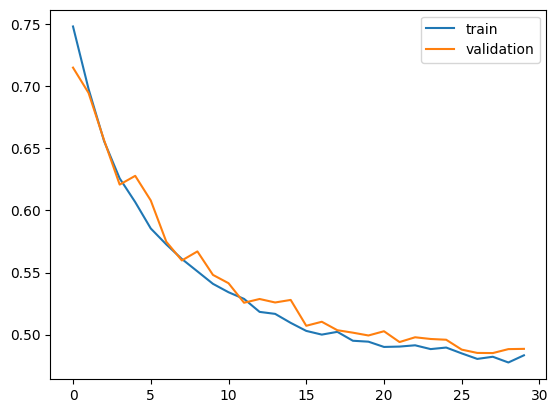

In [20]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

Finally we compute our IOU score for various thresholds. 

In [21]:
y_pred_true_pairs = []
for images, masks in val_loader:
    # images = Variable(images.cuda())
    images = Variable(images.cpu())
    y_preds = model(images)
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.cpu().data.numpy()
        y_pred_true_pairs.append((y_pred, masks[i].numpy()))

We use a method to calculate the IOU score as found in this kernel here: https://www.kaggle.com/leighplt/goto-pytorch-fix-for-v0-3.


In [22]:
# https://www.kaggle.com/leighplt/goto-pytorch-fix-for-v0-3
for threshold in np.linspace(0, 1, 11):
    
    ious = []
    for y_pred, mask in y_pred_true_pairs:
        prediction = (y_pred > threshold).astype(int)
        iou = jaccard_score(mask.flatten(), prediction.flatten(), zero_division=1)
        ious.append(iou)
        
    accuracies = [np.mean(ious > iou_threshold)
                 for iou_threshold in np.linspace(0.5, 0.95, 10)]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))

Threshold: 0.0, Metric: 0.068
Threshold: 0.1, Metric: 0.068
Threshold: 0.2, Metric: 0.081
Threshold: 0.3, Metric: 0.067
Threshold: 0.4, Metric: 0.045
Threshold: 0.5, Metric: 0.020
Threshold: 0.6, Metric: 0.004
Threshold: 0.7, Metric: 0.001
Threshold: 0.8, Metric: 0.000
Threshold: 0.9, Metric: 0.000
Threshold: 1.0, Metric: 0.000


# Reference

- https://www.kaggle.com/code/erikistre/pytorch-basic-u-net/notebook

## 定義訓練和攻擊函數

```
def train_with_dp(model, train_loader, criterion, optimizer, noise_scale=0.1, clip_value=1.0, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch_data, batch_target in train_loader:
            optimizer.zero_grad()
            output = model(batch_data)
            loss = criterion(output, batch_target)
            loss.backward()
            
            # 進行梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            # 添加高斯噪聲
            for param in model.parameters():
                if param.grad is not None:
                    noise = torch.randn_like(param.grad) * noise_scale
                    param.grad += noise

            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
```

## 訓練模型

```
model = SimpleUNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_with_dp(model, train_loader, criterion, optimizer)
```

Attack Iteration 0, Loss: 1.9196562767028809
Attack Iteration 100, Loss: -0.2858385145664215
Attack Iteration 200, Loss: -1.608534574508667
Attack Iteration 300, Loss: -2.595371961593628
Attack Iteration 400, Loss: -3.3947439193725586
Attack Iteration 500, Loss: -4.0661540031433105
Attack Iteration 600, Loss: -4.667995452880859
Attack Iteration 700, Loss: -5.221607208251953
Attack Iteration 800, Loss: -5.751162528991699
Attack Iteration 900, Loss: -6.255782127380371


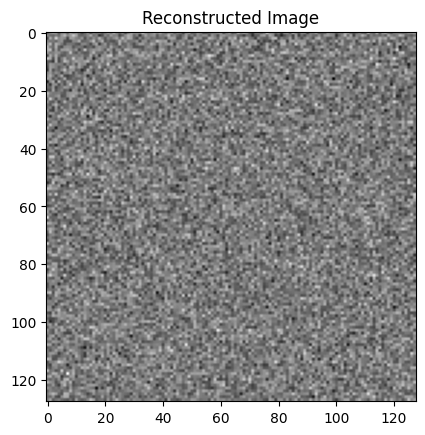

In [23]:
# Model Inversion Attack
def model_inversion_attack(model, target_shape, iterations=1000, lr=0.01):
    model.eval()
    reconstructed_image = torch.randn(target_shape, requires_grad=True)  # 隨機初始化攻擊影像
    #optimizer_attack = optim.Adam(, lr=lr)
    optimizer_attack = torch.optim.Adam([reconstructed_image], lr=learning_rate)
    for i in range(iterations):
        optimizer_attack.zero_grad()
        output = model(reconstructed_image)
        loss = -torch.mean(output)  # 嘗試最大化模型輸出
        loss.backward()
        optimizer_attack.step()

        if i % 100 == 0:
            print(f"Attack Iteration {i}, Loss: {loss.item()}")

    return reconstructed_image.detach()

# 執行攻擊並顯示結果
reconstructed_image = model_inversion_attack(model, (1, 1, im_height, im_width))

plt.imshow(reconstructed_image[0][0].cpu().detach().numpy(), cmap='gray')
plt.title("Reconstructed Image")
plt.show()

In [24]:
model_ndp = Unet()
# model.cuda();
model_ndp.cpu();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
mean_train_losses = []
mean_val_losses = []
for epoch in range(30):
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        # images = Variable(images.cuda())
        # masks = Variable(masks.cuda())
        images = Variable(images.cpu())
        masks = Variable(masks.cpu())        
        outputs = model_ndp(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, masks in val_loader:
        # images = Variable(images.cuda())
        # masks = Variable(masks.cuda())
        images = Variable(images.cpu())
        masks = Variable(masks.cpu())
        
        outputs = model_ndp(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))

Epoch: 1. Train Loss: 0.6445301175117493. Val Loss: 0.6456471085548401
Epoch: 2. Train Loss: 0.6451224684715271. Val Loss: 0.6456471085548401
Epoch: 3. Train Loss: 0.6448644995689392. Val Loss: 0.6456471085548401
Epoch: 4. Train Loss: 0.644717276096344. Val Loss: 0.6456471085548401
Epoch: 5. Train Loss: 0.6447404623031616. Val Loss: 0.6456471085548401
Epoch: 6. Train Loss: 0.645494282245636. Val Loss: 0.6456471085548401
Epoch: 7. Train Loss: 0.6453812718391418. Val Loss: 0.6456471085548401
Epoch: 8. Train Loss: 0.6450523734092712. Val Loss: 0.6456471085548401
Epoch: 9. Train Loss: 0.6448262333869934. Val Loss: 0.6456471085548401
Epoch: 10. Train Loss: 0.6459656357765198. Val Loss: 0.6456471085548401
Epoch: 11. Train Loss: 0.6453743577003479. Val Loss: 0.6456471085548401
Epoch: 12. Train Loss: 0.645910382270813. Val Loss: 0.6456471085548401
Epoch: 13. Train Loss: 0.6448298692703247. Val Loss: 0.6456471085548401
Epoch: 14. Train Loss: 0.6451438069343567. Val Loss: 0.6456471085548401
Epoc

In [26]:
# Model Inversion Attack
def model_inversion_attack(model_ndp, target_shape, iterations=1000, lr=0.01):
    model_ndp.eval()
    reconstructed_image = torch.randn(target_shape, requires_grad=True)  # 隨機初始化攻擊影像
    # optimizer_attack = optim.Adam([reconstructed_image], lr=lr)
    optimizer_attack = torch.optim.Adam([reconstructed_image], lr=learning_rate)
    for i in range(iterations):
        optimizer_attack.zero_grad()
        output = model_ndp(reconstructed_image)
        loss = -torch.mean(output)  # 嘗試最大化模型輸出
        loss.backward()
        optimizer_attack.step()

        if i % 100 == 0:
            print(f"Attack Iteration {i}, Loss: {loss.item()}")

    return reconstructed_image.detach()

Attack Iteration 0, Loss: 10.460558891296387
Attack Iteration 100, Loss: 8.505141258239746
Attack Iteration 200, Loss: 7.1945013999938965
Attack Iteration 300, Loss: 6.203708171844482
Attack Iteration 400, Loss: 5.419983386993408
Attack Iteration 500, Loss: 4.800215721130371
Attack Iteration 600, Loss: 4.2829999923706055
Attack Iteration 700, Loss: 3.8399410247802734
Attack Iteration 800, Loss: 3.4565954208374023
Attack Iteration 900, Loss: 3.1254098415374756


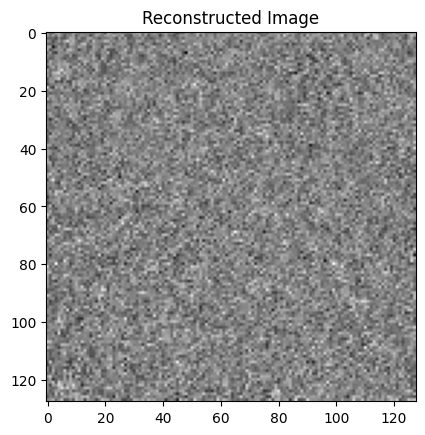

In [27]:
# 執行攻擊並顯示結果
reconstructed_image = model_inversion_attack(model_ndp, (1, 1, im_height, im_width))

plt.imshow(reconstructed_image[0][0].cpu().detach().numpy(), cmap='gray')
plt.title("Reconstructed Image")
plt.show()